# Performance comparison of OFDM and DFT-s-OFDM in 5G Networks

Orthogonal Frequency Division Multiplexing (OFDM) is a modulation technique used in wireless communication systems to transmit data over radio waves. It works by dividing the available spectrum into multiple orthogonal (non-overlapping) subcarriers, each carrying one constellation symbol. These subcarriers are spaced apart at precise intervals, ensuring they do not interfere with each other. OFDM is widely used in various wireless communication standards such as Wi-Fi, LTE (Long-Term Evolution), WiMAX, and 5G due to its ability to provide high-speed data transmission, robustness to interference, and efficient spectrum utilization. In this chapter, we will discuss the design of OFDM used in the air interface of the 5G networks.

**Table of Content**:


1. [Import Libraries](#Import-Libraries)
    - [Import Python Libraries](#Import-Python-Libraries)
    - [Import 5G-Toolkit Libraries](#Import-5G-Toolkit-Libraries)
2. [Simulation Parameters](#Simulation-Parameters)
3. [Peak to Average Power Ratio (PAPR) Analysis](#Peak-to-Average-Power-Ratio-(PAPR)-Analysis)
    - [PAPR Analysis: CP-OFDM](#PAPR-Analysis:-CP-OFDM)
    - [PAPR Analysis: DFT-s-OFDM](#PAPR-Analysis:-DFT-s-OFDM)
    - [PAPR Performance Comparison: CP-OFDM vs DFT-s-OFDM](#PAPR-Performance-Comparison:-CP-OFDM-vs-DFT-s-OFDM)
5. [ACLR Analysis: CP-OFDM vs DFT-s-OFDM](#ACLR-Analysis:-CP-OFDM-vs-DFT-s-OFDM)
5. [ACLR Comparison of OFDM and DFT-s-OFDM](#ACLR-Comparison-of-OFDM-and-DFT-s-OFDM)
5. [References](#References)













## Import Libraries
### Import Python Libraries

In [1]:
# %matplotlib widget

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 12
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.style'] = 'normal'

import numpy as np


## Import 5G-Toolkit Libraries

In [2]:
import sys
sys.path.append("../../../")

from toolkit5G.OFDM          import OFDMModulator, OFDMDemodulator
from toolkit5G.OFDM          import transformPrecoding5G, transformDecoding5G
from toolkit5G.SymbolMapping import Mapper, Demapper

## Simulation Parameters

In [3]:
modOrder   = 4
constType  = "qam"  # Symbol mapping type

numBatches = 10000
scs        = 15000

fftSizes   = np.array([128, 256, 512, 1024], dtype=np.int32)
binSize    = 512

## Peak to Average Power Ratio (PAPR) Analysis

![CP-OFDM](OFDMTx.png)

### PAPR Analysis: CP-OFDM

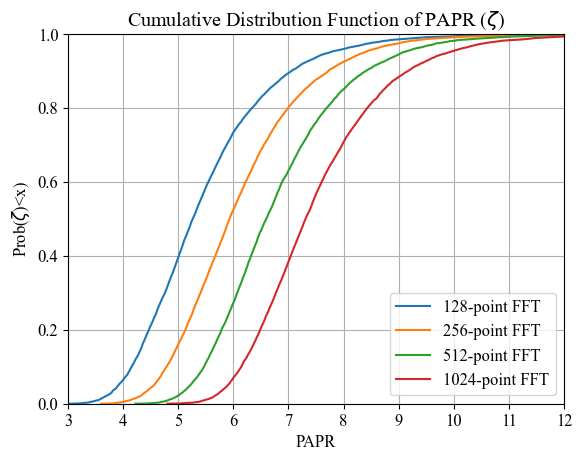

In [4]:

######################################################################
cyclic_prefix_length = 72
ofdm = OFDMModulator(cyclic_prefix_length)
######################################################################

cdfOFDM      = np.zeros((fftSizes.size, binSize))
binCountOFDM = np.zeros((fftSizes.size, binSize))
# plotting PDF and CDF
fig, ax = plt.subplots()


for i in range(fftSizes.size):
    fftSize = fftSizes[i]
    numBits = int(fftSize*modOrder)
    

    ######################################################################
    # Generate the bits for modulation
    bits      = np.random.randint(2, size = (numBatches, 1, numBits))



    # Symbol mapping object
    mapper    = Mapper(constType, modOrder)
    symbols   = mapper(bits) # Generate symbols from the bits.
    ######################################################################
    
    samples = ofdm(symbols)

    samplesPower    = np.abs(samples)**2
    avgPowerOutput  = np.mean(samplesPower,axis=-1)
    peakPowerOutput = np.max(samplesPower, axis=-1)

    
    pointPAPROutput = peakPowerOutput/avgPowerOutput
    
    countOut, bins_countOut = np.histogram(pointPAPROutput, bins=binSize)

    # finding the PDF of the histogram using count values
    pdf = countOut/sum(countOut)

    # using numpy np.cumsum to calculate the CDF
    # We can also find using the PDF values by looping and adding
    cdf = np.cumsum(pdf)
    ax.plot(bins_countOut[1:], cdf, label = str(fftSize)+"-point FFT")       
    
    cdfOFDM[i] = cdf
    binCountOFDM[i] = bins_countOut[1:]
    
ax.set_xlim([3,12])
ax.set_ylim([0, 1])
ax.legend()
ax.set_title("Cumulative Distribution Function of PAPR ($\\zeta$)")
ax.set_xlabel("PAPR")
ax.set_ylabel("Prob($ \\zeta $)<x)")
ax.grid()

plt.show()

# fig.savefig("PAPR_OFDM.svg", format = "svg")
# fig.savefig("PAPR_OFDM.png", format = "png")

### PAPR Analysis: DFT-s-OFDM

![DFT-s-OFDM](DFT-s-OFDM.png)

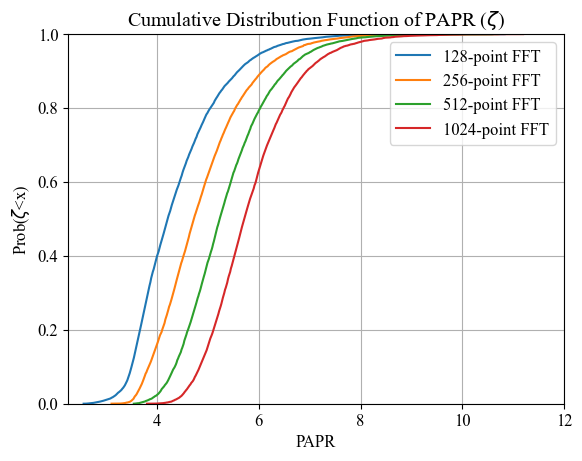

In [5]:
modOrder   = 4
numBatches = 10000
fftSizes   = np.array([128, 256, 512, 1024], dtype=np.int32)
binSize    = 512

constType = "qam"  # Symbol mapping type
    
######################################################################
cyclic_prefix_length = 32
ofdm = OFDMModulator(cyclic_prefix_length)
######################################################################

cdfDFT      = np.zeros((fftSizes.size, binSize))
binCountDFT = np.zeros((fftSizes.size, binSize))

# plotting PDF and CDF
fig, ax = plt.subplots()

numSC = 64       # Defines the spreading factor used for DFT-s-OFDM

for i in range(fftSizes.size):
    fftSize = fftSizes[i]
    numSCs  = int(numSC*2**i)
    numBits = int(numSCs*modOrder)
    
    symbols   = np.zeros((numBatches, 1, fftSize), dtype = np.complex64)
    
    scale = int(np.floor(fftSize/(numSCs)))
    for j in range(scale):
        ######################################################################
        # Generate the bits for modulation
        bits   = np.random.randint(2, size = (numBatches, 1, numBits))

        # Symbol mapping object
        mapper = Mapper(constType, modOrder)
        symbs  = mapper(bits) # Generate symbols from the bits.
        
        fs     = j*numSCs
        ls     = (j+1)*numSCs
        symbols[...,fs:ls] = np.fft.fft(symbs, norm = "ortho", axis = -1)
#     print(symbols.shape)
    ######################################################################
    
    samples = ofdm(symbols)
#     print(samples.shape)

    samplesPower    = np.abs(samples)**2
#     samplesPower    = np.where(samplesPower<0.00001, 0.00001,samplesPower)
    avgPowerOutput  = np.mean(samplesPower,axis=-1)
    peakPowerOutput = np.max(samplesPower, axis=-1)
#     print(peakPowerOutput.max())
#     print(peakPowerOutput.mean())
#     pointPAPROutput = (peakPowerOutput[:,np.newaxis]/samplesPower).flatten()
#     pointPAPROutput = (samplesPower/avgPowerOutput[:,np.newaxis]).flatten()
    
    pointPAPROutput = peakPowerOutput/avgPowerOutput
    
    countOut, bins_countOut = np.histogram(pointPAPROutput, bins=binSize)

    # finding the PDF of the histogram using count values
    pdf = countOut/sum(countOut)

    # using numpy np.cumsum to calculate the CDF
    # We can also find using the PDF values by looping and adding
    cdf = np.cumsum(pdf)

    ax.plot(bins_countOut[1:], cdf, label = str(fftSize)+"-point FFT")     
    
    cdfDFT[i]      = cdf
    binCountDFT[i] = bins_countOut[1:]

ax.set_xlim([2.25, 12])
ax.set_ylim([0, 1])
ax.legend()
ax.set_title("Cumulative Distribution Function of PAPR ($\\zeta$)")
ax.set_xlabel("PAPR")
ax.set_ylabel("Prob($ \\zeta $<x)")
ax.grid()

plt.show()

fig.savefig("PAPR_DFT-s-OFDM.svg", format = "svg")
fig.savefig("PAPR_DFT-s-OFDM.png", format = "png")

array([ 128,  256,  512, 1024], dtype=int32)

## PAPR Performance Comparison: CP-OFDM vs DFT-s-OFDM

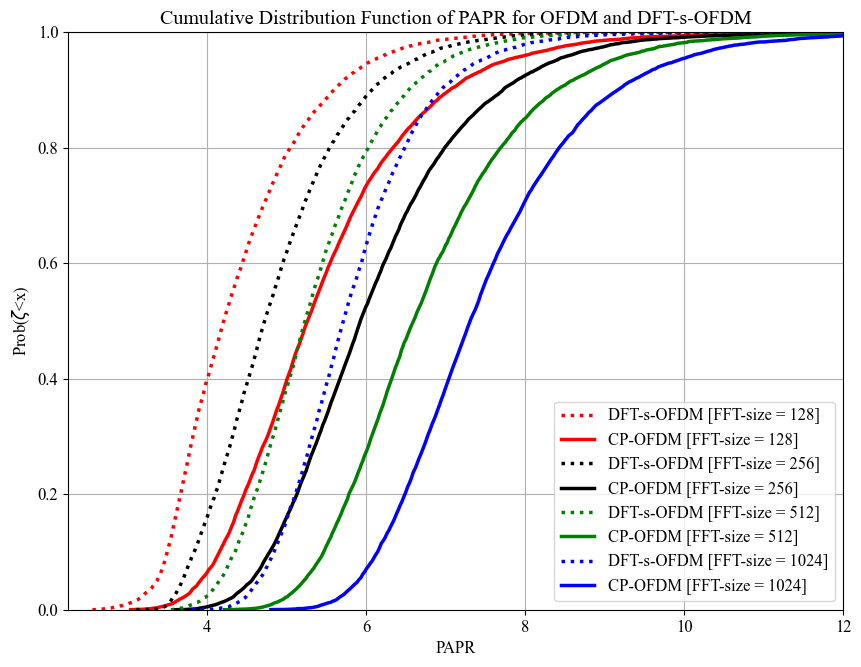

In [7]:
fig, ax = plt.subplots(figsize=(10,7.5))

color  = ["red", "black", "green", "blue"]
marker = ["o", "*", "P", "s"]

for i in range(fftSizes.size):
    ax.plot(binCountDFT[i],  cdfDFT[i],  ls = ":", lw = 2.5, color = color[i], label = "DFT-s-OFDM [FFT-size = "+str(fftSizes[i])+"]")
    ax.plot(binCountOFDM[i], cdfOFDM[i], ls = "-", lw = 2.5, color = color[i], label = "CP-OFDM [FFT-size = "+str(fftSizes[i])+"]")
    ax.legend()

ax.set_xlim([2.25, 12])
ax.set_ylim([0, 1])

ax.set_title("Cumulative Distribution Function of PAPR for OFDM and DFT-s-OFDM")
ax.set_xlabel("PAPR")
ax.set_ylabel("Prob($ \\zeta $<x)")
ax.grid()

plt.show()
# fig.savefig("PAPR_Comparison.svg", format = "svg")
# fig.savefig("PAPR_Comparison.png", format = "png")

## ACLR Analysis: CP-OFDM vs DFT-s-OFDM

In [8]:

######################################################################
fc      = 3.6*10**9
cyclic_prefix_length = 72
ofdm    = OFDMModulator(cyclic_prefix_length)
fftSize = 256
scs     = 3000
######################################################################

symbolPeriod   = 1/scs
symbolPeriodCP = symbolPeriod + cyclic_prefix_length/(scs*fftSize)
scsCP          = 1/symbolPeriodCP
numBatches     = 100
numBits = int(fftSize*modOrder)
bits    = np.random.randint(2, size = (numBatches, 1, numBits))

# Symbol mapping object
mapper  = Mapper(constType, modOrder)
symbs   = mapper(bits) # Generate symbols from the bits.

f       = fc + np.linspace(-fftSize*scs,fftSize*scs, int(1.5*fftSize)) 

Sf      = np.abs(np.sqrt(symbolPeriodCP)*(symbs*np.sinc((f.reshape(-1,1)-fc-scs*np.arange(-fftSize/2,fftSize/2,1).reshape(1,-1))/scsCP)[np.newaxis])).sum(-1).mean(0)

##########################################
############### DFT-s-OFDM ###############
##########################################
numSCs  = 16
numBits = int(numSCs*modOrder)
    
symbols   = np.zeros((numBatches, 1, fftSize), dtype = np.complex64)
    
scale = int(np.floor(fftSize/numSCs))
for j in range(scale):
    ######################################################################
    # Generate the bits for modulation
    bits   = np.random.randint(2, size = (numBatches, 1, numBits))

    # Symbol mapping object
    mapper = Mapper(constType, modOrder)
    symbs  = mapper(bits) # Generate symbols from the bits.

    fs     = j*numSCs
    ls     = (j+1)*numSCs
    symbols[...,fs:ls] = np.fft.fft(symbs, norm = "ortho", axis = -1)
     
f       = fc + np.linspace(-fftSize*scs,fftSize*scs, int(1.5*fftSize)) 

Sf2     = np.abs(np.sqrt(symbolPeriodCP)*(symbols*np.sinc((f.reshape(-1,1)-fc-scs*np.arange(-fftSize/2,fftSize/2,1).reshape(1,-1))/scsCP)[np.newaxis])).sum(-1).mean(0)


((100, 1, 16), (384,))

## ACLR Comparison of OFDM and DFT-s-OFDM

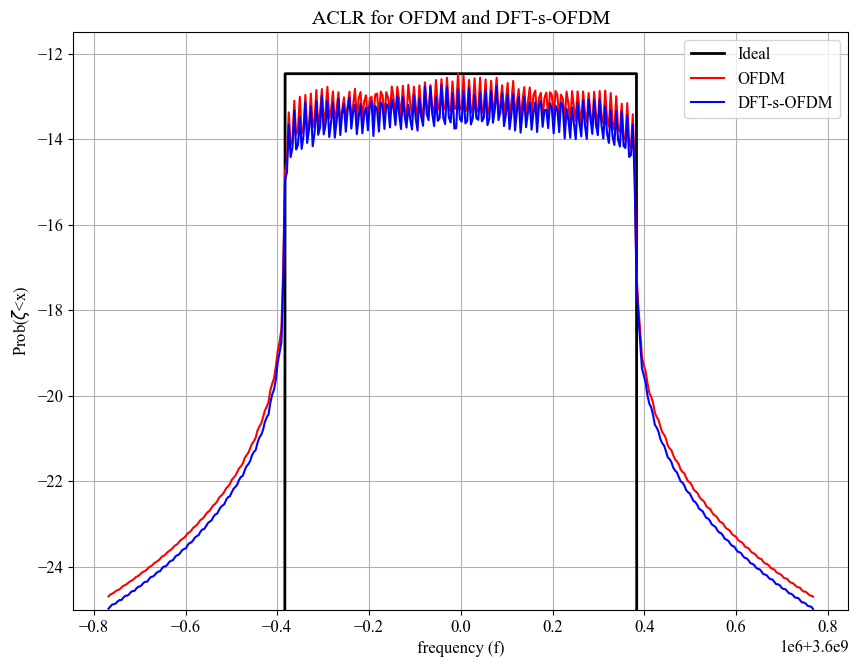

In [10]:
fig, ax = plt.subplots(figsize=(10,7.5))

amplitude = Sf.max()*np.ones(f.size)
amplitude[f-fc<-0.5*fftSize*scs] = 10**-10
amplitude[f-fc>0.5*fftSize*scs]  = 10**-10


ax.plot(f, 10*np.log10(amplitude), "k", lw = 2, label = "Ideal")
ax.plot(f, 10*np.log10(Sf),  "r", label = "OFDM")
ax.plot(f, 10*np.log10(Sf2), "b", label = "DFT-s-OFDM")
ax.legend()
# ax.set_xlim([2.25, 12])
ax.set_ylim([-25, -11.5])

ax.set_title("ACLR for OFDM and DFT-s-OFDM")
ax.set_xlabel("frequency (f)")
ax.set_ylabel("Prob($ \\zeta $<x)")
ax.grid()

plt.show()

# fig.savefig("PAPR_Comparison.svg", format = "svg")
# fig.savefig("PAPR_Comparison.png", format = "png")

## References
Precise definition for PAPR and ACLR can be found in the following tutorials:

1. [Learning OFDM Waveforms with PAPR and ACLR Constraints](https://arxiv.org/pdf/2110.10987)